# Machine Translation: seq2seq model

In [ ]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import collections
import numpy as np

# Making relevant import statements for layers of the model.
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Embedding
from tensorflow.keras.models import Model

# Model optimizer and loss parameters
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

Verify access to the GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# 1. Load Data
The dataset used for this task contains small vocabulary (200 ~ 300 words). 

In [ ]:
import os 
path = os.getcwd()

In [ ]:
with open(os.path.join(path, 'data/small_vocab_en', 'r')) as f:
    eng_sentences = f.read().split('\n')
    
with open(os.path.join(path, 'data/small_vocab_fr', 'r')) as f:
    fre_sentences = f.read().split('\n')

print('Dataset Loaded')

Dataset Loaded


In [ ]:
for sample_i in range(2):
    print('English Sentence {} :  {}'.format(sample_i+1, eng_sentences[sample_i]))
    print('French Sentence {}  :  {}\n'.format(sample_i+1, fre_sentences[sample_i]))

English Sentence 1 :  new jersey is sometimes quiet during autumn , and it is snowy in april .
French Sentence 1  :  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English Sentence 2 :  the united states is usually chilly during july , and it is usually freezing in november .
French Sentence 2  :  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .



# 2. Pre-process text


## 2.1. Tokenize function

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(x, encode_start_end = False):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :param encode_start_end: if True, pad the start & end of sentence as separate tokens
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # A start and end token is added to the sentence in a way that 
    # the start and end tokens are not similar to any other tokens occuring in the dataset.
    if encode_start_end:
        x = ["startofsentence " + sentence + " endofsentence" for sentence in x]
    tokenizer = Tokenizer()                         # Tokenizer instantiated
    tokenizer.fit_on_texts(x)                        # 
    tokenized_x = tokenizer.texts_to_sequences(x)
    
    return tokenized_x, tokenizer

## 2.2. Padding  function

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x])
    
    # pad_sequences pads the input to the configurations mentioned such as length, 
    # position of padding, and removal(truncating) of characters if necessary.
    padded_x = pad_sequences(x, maxlen = length, padding = 'post', truncating = 'post')
    
    return padded_x

## 2.3. Execute both functions

In [ ]:
# Tokenization of english and french sentences, 
# where french has padded start and end tokens for RNN's performance.
eng_tokenized, eng_tokenizer = tokenize(eng_sentences)
fre_tokenized, fre_tokenizer = tokenize(fre_sentences, encode_start_end = True)

# Padding and expanding dimensions of the inputs and outputs.
eng_encoded = np.expand_dims(pad(eng_tokenized), axis=-1)
fre_encoded = np.expand_dims(pad(fre_tokenized), axis=-1)

# Recording the sizes of each vocabularies for further ease of usage.
eng_vocab_size = len(eng_tokenizer.word_index)
fre_vocab_size = len(fre_tokenizer.word_index)

print("English vocabulary size: ", eng_vocab_size)
print("French vocabulary size: ", fre_vocab_size)
print()

eng_seq_len = len(eng_encoded[0])
fre_seq_len = len(fre_encoded[0])
        
print("Length of longest English sentence: ", eng_seq_len)
print("Length of longest French sentence: ", fre_seq_len)


English vocabulary size:  199
French vocabulary size:  346

Length of longest English sentence:  15
Length of longest French sentence:  23


In [ ]:
print("Shape of English encoded tokens: ", eng_encoded.shape)
print("Shape of French encoded tokens: ", fre_encoded.shape)

Shape of English encoded tokens:  (137861, 15, 1)
Shape of French encoded tokens:  (137861, 23, 1)


# 3. Build Seq2Seq Model & Train


## 3.1. Training model


In [ ]:
# Starting building the model by importing the LSTM unit for RNN's implementation
from keras.layers import LSTM

english_input = eng_encoded   # (137861, 15,)

# 
decoder_french_input = fre_encoded[:, :-1, :]
decoder_french_target = fre_encoded[:, 1:, :]
    
# 1. Define Encoder
input_seq_encoder = Input(shape = (None, ),
                          name = "encoder_input")     # (batch_size, sentence_length, 1) 

embed_dim = 200
embedded_seq_encoder = Embedding(input_dim = eng_vocab_size, 
                                 output_dim = embed_dim)(input_seq_encoder)

encoder_lstm = LSTM(units = 256,             
                    activation = 'relu',
                    return_sequences = False,
                    return_state = True,
                    name = "encoder_LSTM")

_, last_hidden_encoder, last_cell_encoder = encoder_lstm(embedded_seq_encoder)


# 2. Define Decoder
input_seq_decoder = Input(shape = (None, 1),
                          name = "decoder_input")     # (batch_size, sentence_length, 1)

decoder_lstm = LSTM(units = 256,                          
                    activation = 'relu',
                    return_sequences = True,
                    return_state = True,
                    name = "decoder_LSTM")

all_hidden_decoder, _, _ = decoder_lstm(input_seq_decoder, 
                                        initial_state = [last_hidden_encoder, last_cell_encoder])

decoder_dense = Dense(fre_vocab_size,   # NOT TIMEDISTRIBUTED (NOT RECURSIVE)
                      activation = 'softmax',
                      name = "decoder_dense")
logits = decoder_dense(all_hidden_decoder)


# 3. Define Model with appropriate endcoded input layers and output layers.
final_rnn_model = Model(inputs = [input_seq_encoder, input_seq_decoder],
                        outputs = logits)

final_rnn_model.compile(loss = sparse_categorical_crossentropy,
                        optimizer = Adam(lr = 0.002),
                        metrics = ['accuracy'])



In [ ]:
final_rnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    39800       ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_LSTM (LSTM)            [(None, 256),        467968      ['embedding[0][0]']              
                                 (None, 256),                                                 

In [ ]:
# 4. Fit the Model
final_rnn_model.fit([english_input, decoder_french_input],
                    decoder_french_target,
                    batch_size = 1024,
                    epochs = 16,
                    validation_split = 0.2)

Epoch 1/16
108/108 [==============================] - 25s 178ms/step - loss: 1.7328 - accuracy: 0.6063 - val_loss: nan - val_accuracy: 0.7367
Epoch 2/16
108/108 [==============================] - 21s 199ms/step - loss: 0.6562 - accuracy: 0.7824 - val_loss: nan - val_accuracy: 0.8153
Epoch 3/16
108/108 [==============================] - 18s 169ms/step - loss: 0.4674 - accuracy: 0.8378 - val_loss: nan - val_accuracy: 0.8440
Epoch 4/16
108/108 [==============================] - 18s 169ms/step - loss: 0.3373 - accuracy: 0.8814 - val_loss: nan - val_accuracy: 0.8953
Epoch 5/16
108/108 [==============================] - 18s 169ms/step - loss: 0.2142 - accuracy: 0.9259 - val_loss: nan - val_accuracy: 0.9430
Epoch 6/16
108/108 [==============================] - 18s 170ms/step - loss: 0.1134 - accuracy: 0.9622 - val_loss: nan - val_accuracy: 0.9764
Epoch 7/16
108/108 [==============================] - 19s 174ms/step - loss: 0.1143 - accuracy: 0.9653 - val_loss: nan - val_accuracy: 0.9834
Epoch 

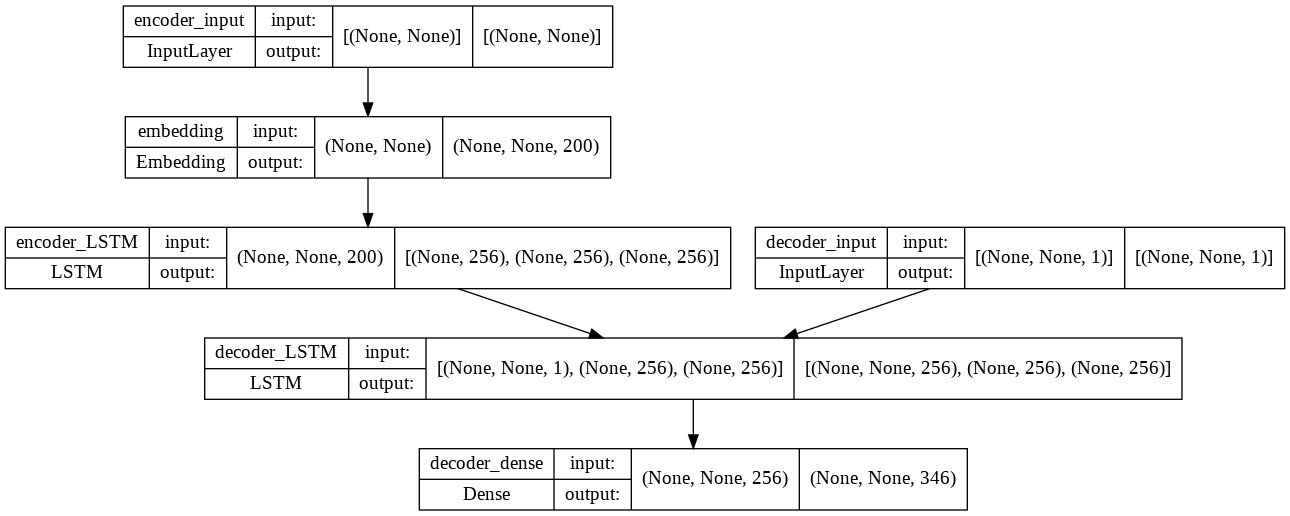

In [ ]:
# This uses a Keras visualization tool to summarize the model and should
# confirm what you reviewed in the table above.
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(final_rnn_model, show_shapes=True, show_layer_names=True)

# Image will be saved under the name 'model.png'
Image('model.png')

## 3.2. Inference model


### 3.2.1. Encoder Model for inference

In [ ]:
last_states_encoder = [last_hidden_encoder, last_cell_encoder]
inference_encoder_model = Model(inputs = input_seq_encoder, 
                                outputs = last_states_encoder)

### 3.2.2. Decoder Model for inference

In [ ]:
decoder_initial_state = [Input(shape = (256,)), Input(shape = (256,))]  
all_hidden_decoder, last_hidden_decoder, last_cell_decoder = decoder_lstm(input_seq_decoder, 
                                                                          initial_state = decoder_initial_state)
logits = decoder_dense(all_hidden_decoder)
inference_decoder_model = Model(inputs  = [input_seq_decoder] + decoder_initial_state, 
                                outputs = [logits, 
                                          last_hidden_decoder, 
                                          last_cell_decoder])

### 3.2.3. Decode Sequence Function

In [ ]:
target_id_to_word = {idx:word for word, idx in fre_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    """
    Gets predictions using the final model defined above
    :param input_seq: (list) encoded english sentence (list of word ids)
    returns : translated French sentence
    """
    decoder_input = inference_encoder_model.predict(input_seq)

    # Initialize decoder input as a length 1 sentence containing "startofsentence",
    # --> feeding the start token as the first predicted word
    prev_word = np.zeros((1, 1, 1))
    prev_word[0, 0, 0] = fre_tokenizer.word_index["startofsentence"]

    stop_condition = False
    translation = []
    while not stop_condition:
        # 1. predict the next word using decoder model
        logits, last_h, last_c = inference_decoder_model.predict([prev_word] + decoder_input)
        
        # 2. Update prev_word with the predicted word
        predicted_id = np.argmax(logits[0, 0, :])
        predicted_word = target_id_to_word[predicted_id]
        translation.append(predicted_word)

        # 3. Enable End Condition: (1) if predicted word is "endofsentence" OR
        #                          (2) if translated sentence reached maximum sentence length
        if (predicted_word == 'endofsentence' or len(translation) > decoder_french_target.shape[1]):
            stop_condition = True

        # 4. Update prev_word with the predicted word
        prev_word[0, 0, 0] = predicted_id

        # 5. Update initial_states with the previously predicted word's encoder output
        decoder_input = [last_h, last_c]

    return " ".join(translation).replace('endofsentence', '')

## 3.3. Predictions

In [ ]:
# TODO: Print prediction(s)
for i in [293, 296, 393, 418]:
    english_seq = eng_encoded[i].reshape(1, eng_encoded.shape[1])
    french_translation = decode_sequence(english_seq)
    
    print("English Sentence            : ", eng_sentences[i])
    print("Predicted French Translation: ", french_translation)
    print("Correct French Translation  : ", fre_sentences[i])
    print()

English Sentence            :  i plan to visit france in spring .
Predicted French Translation:  je prévois de visiter la france au printemps 
Correct French Translation  :  je prévois de visiter la france au printemps .

English Sentence            :  she likes grapes , apples , and grapefruit.
Predicted French Translation:  elle aime les raisins les pommes et le pamplemousse 
Correct French Translation  :  elle aime les raisins , les pommes et le pamplemousse .

English Sentence            :  my most loved animal was that bird .
Predicted French Translation:  mon animal le plus aimé était cet oiseau 
Correct French Translation  :  mon animal le plus aimé était cet oiseau .

English Sentence            :  france is pleasant during july , but it is usually dry in december .
Predicted French Translation:  la france est agréable en juillet mais il est généralement sec en décembre 
Correct French Translation  :  la france est agréable en juillet , mais il est généralement sec en décembre 

seems like perfect translations for the standarad of the simple dataset with limited vocabulary!